In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import glm
import statsmodels.api as sm

### Problem 1
This problem walks us through a problem discussed in detail in the Multi-level regression book written by A. Gelman and J. Hill. NYC has a program known as stop-and-frisk. Relying on a 60’s era ruling, the law allows an officer to search someone without arrest, and without probable cause, if the officer believes s/he might be in danger because of a hidden weapon. Much has been written about this, as it has come under significant scrutiny for being discriminative and allowing (even encouraging) racial profiling. You can read a summary of it at this Wikipedia page: https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City.
The data you will download contain information about the number of traffic stops, reported per precinct (75 total precincts), along with the ethnicity as reported by the police officer. These data have kept only three ethnicities: white, black and hispanic. The data set also has data on arrest rates in the previous year, broken down by four types of crimes; and the total population levels per precinct per ethnic group.

#### 1. Download and load the data in the file NYC stop and frisk.dat, uploaded to Canvas.

In [0]:
infile = open('./NYC_stop_and_frisk.dat')
df = pd.read_csv('./NYC_stop_and_frisk.dat', sep = ' ', skiprows = 5)
df.rename(columns={'past.arrests':'pastarrests'}, inplace=True)
ethnicity={1:'black',2:'hispanic',3:'white'}
df['eth'].replace(ethnicity, inplace = True)
crimes={1:'violent',2:'weapons',3:'property',4:'drug'}
df.head()

#### 2. What fraction of the total stops correspond to “white/back/hispanic”? What fraction of the population corresponds to “white/black/hispanic”?

In [0]:
total_stops = df['stops'].sum()
total_pop = df['pop'].sum()
output_df = df.groupby('eth').sum()[['stops','pop']]
output_df['stops'] = output_df['stops']/total_stops
output_df['pop'] = output_df['pop']/total_pop
output_df

#### 3. Use a Poisson regression to model the number of stops, controlling for ethnicity and using the number of past arrests as an exposure input.

In [0]:
df = df.join(pd.get_dummies(df['eth']))
df['pastarrests'].replace(0,1, inplace=True)

poisson_training_results = glm('stops ~ black + hispanic', exposure = df['pastarrests'],data = df, family = sm.families.Poisson()).fit()
poisson_training_results.summary()

In [0]:
np.exp(poisson_training_results.params)

#### 4. According to the output of your model, what fraction fewer or more stops does each ethnicity have with respect to the others, in proportion to arrest rates of the previous year? Note that you can just pick a baseline ethnicity and just compare everything to that.

According to the model, there are 17.54% more stops for black ethnicity and 26.09% more stops for hispanic ethnicity when compared to the baseline white ethnicity, in proportion to arrest rates of the previous year.

#### 5. Next, add the 75 precincts, and again solve the Poisson regression model.

In [0]:
pc_df = df.join(pd.get_dummies(df['precinct'], prefix = 'pc'))

poisson_training_results = glm('stops ~ black + hispanic + '+' + '.join(pc_df.columns[9:]), 
                               exposure = pc_df['pastarrests'],data = pc_df, family = sm.families.Poisson()).fit()
poisson_training_results.summary()

In [0]:
np.exp(poisson_training_results.params)

#### 6. Now, controlling for precincts, according to your model, what fraction fewer or more stops does each ethnicity have with respect to the others, in proportion to arrest rates of the previous year? (Again, just report with respect to a chosen ethnicity as a baseline).

Now after controlling for precincts, there is a 52.05% increase in stops for black ethnicity and 53.60% increase in stops for hispanic ethnicity compared to baseline white ethnicity in proportion to arrest rates of the previous year.

### Problem 2
In this problem you will play with the idea of compound models. I have created a data set (entirely fake!)2 of 2012 salaries in the NBA, of 10,000 basketball players that were in high-school in 2011: nba cc fake data.csv. Note that the vast majority of the salaries are equal to 0 because the vast majority of these high-school players did not make it to the NBA and hence their NBA salary equals zero.
There are three features you will use: height (in inches), average points scored during the last year in high school competition, and a scoring from 1-10 of the competitiveness of the league these players played in, with 10 being the most competitive.
The goal is to build a model to predict the NBA salary of a high school baller.

In [0]:
df = pd.read_csv("nba_cc_fake_data.csv", sep=',').drop(columns=['Unnamed: 0'])

In [0]:
df.head(10)

,Comp,Height,Points,Salary
0,9.0,76.0,27.0,0.0
1,7.0,78.0,39.0,0.0
2,9.0,76.0,39.0,0.0
3,9.0,74.0,39.0,0.0
4,9.0,74.0,26.0,0.0
5,8.0,75.0,46.0,0.0
6,8.0,78.0,35.0,0.0
7,7.0,75.0,56.0,0.0
8,9.0,77.0,37.0,0.0
9,9.0,78.0,63.0,496315.0


In [0]:
df_cat = df.copy()

In [0]:
df_cat.loc[df_cat['Salary']!=0.0,'Salary']= 1
df_cat.head(10)

,Comp,Height,Points,Salary
0,9.0,76.0,27.0,0.0
1,7.0,78.0,39.0,0.0
2,9.0,76.0,39.0,0.0
3,9.0,74.0,39.0,0.0
4,9.0,74.0,26.0,0.0
5,8.0,75.0,46.0,0.0
6,8.0,78.0,35.0,0.0
7,7.0,75.0,56.0,0.0
8,9.0,77.0,37.0,0.0
9,9.0,78.0,63.0,1.0


#### 1. Explain why linear regression is not appropriate, given the nature of the data.

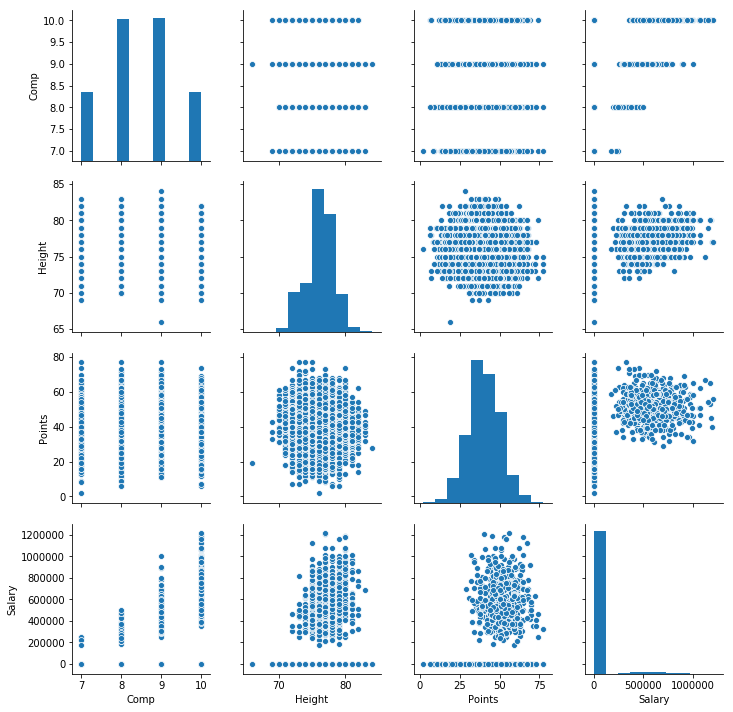

In [0]:
sns.pairplot(df)
sns.despine()

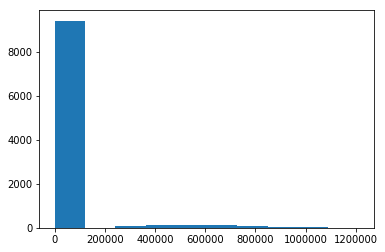

In [0]:
plt.hist(df['Salary'])
plt.show()

#### The linear regression is not appropriate because the distribution of the column "Salary" is so skewed. If we use linear regression to train the data, we would not get reasonable output.

#### 2. Try least squares regression, anyway. How well do you do?

In [0]:
X = df_cat.iloc[:, :3].values
y = df_cat.iloc[:, 3].values

In [0]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
from sklearn.linear_model import LinearRegression
OLS = LinearRegression()
OLS.fit(X_train,y_train).predict(X_test)

y_pred_OLS = OLS.fit(X_train, y_train).predict(X_test)
r2_score_OLS = r2_score(y_test, y_pred_OLS)

In [0]:
print("R^2 on test data : %f" % r2_score_OLS)

R^2 on test data : 0.173903


#### 3. You will next build a composite model. You will first predict the probability that a player actually makes it to the NBA at all, and then you will build a model to predict the salary of a player, conditioned on the fact of making it to the NBA.

– Build a model that predicts the probability of making it to the NBA.

– Do a train-test split of 8000/2000 points, train your best model on the training set, and compute the AUC on the test set.

– Now, build a model to predict the salary. Note that you may wish to consider a non-linear transformation of your data. What is your R2 score on the test set?

In [0]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C=10.0, random_state=0)
lr.fit(X_train, y_train)

/Users/apple/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)

In [0]:
print('Coefficient of are {} and offset/intercept is {}'.format(lr.coef_,lr.intercept_))

Coefficient of are [[1.86639911 1.08771237 1.95787718]] and offset/intercept is [-5.39539326]


In [0]:
# AUC
from sklearn import metrics
test_auc = metrics.roc_auc_score(y_test,y_pred)
print(test_auc)

0.6800432116417247


In [0]:
#build model that predicts the salary
df_salary = df.loc[df['Salary']!=0.0]

In [0]:
df_salary.head()

,Comp,Height,Points,Salary
9,9.0,78.0,63.0,496315.0
27,10.0,76.0,52.0,741265.0
30,8.0,78.0,62.0,292281.0
115,10.0,77.0,63.0,782210.0
117,8.0,76.0,50.0,259365.0


In [0]:
df_salary_log = np.log(df_salary)
df_salary_log.head()

,Comp,Height,Points,Salary
9,2.197225,4.356709,4.143135,13.114966
27,2.302585,4.330733,3.951244,13.516113
30,2.079442,4.356709,4.127134,12.585471
115,2.302585,4.343805,4.143135,13.569879
117,2.079442,4.330733,3.912023,12.465992


In [0]:
X_sal = df_salary_log.iloc[:, :3].values
y_sal = df_salary_log.iloc[:, 3].values

In [0]:
X_sal_train, X_sal_test, y_sal_train, y_sal_test = \
    train_test_split(X_sal, y_sal, test_size=0.2, random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sal_train = sc.fit_transform(X_sal_train)
X_sal_test = sc.transform(X_sal_test)

In [0]:
from sklearn.linear_model import LinearRegression
OLS = LinearRegression()
y_pred_salary = OLS.fit(X_sal_train,y_sal_train).predict(X_sal_test)
r2_score_salary = r2_score(y_sal_test, y_pred_salary)
print("R^2 on test data : %f" % r2_score_salary)

R^2 on test data : 0.684083


#### 4. Compute the expected NBA salary of a high school basketball player who is 6’ 6” tall, is averaging 46 points per game, and is playing in the second most competitive league (comp = 9), according to your model.

In [0]:
data={'Comp_data':['9'], 'Height_data':['78'], 'Points_data':['46']}
df_data = DataFrame(data)

In [0]:
X_data = df_data.iloc[:, :3].values

In [0]:
X_sc_data = sc.fit_transform(X_data)

In [0]:
y_pred_nba= lr.predict_proba(X_sc_data)
print(y_pred_nba)

[[0.99548306 0.00451694]]


#### From our model, we can see this basketball player probably would not get into NBA.

In [0]:
y_pred_salary = OLS.fit(X_sal_train,y_sal_train).predict(X_sc_data)

In [0]:
import math
y_pred_salary_final = math.exp(y_pred_salary)
print("Though he probably would not get into NBA, the predicted Salary is : %f" % y_pred_salary_final)

Though he probably would not get into NBA, the predicted Salary is : 565268.589421
